In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
file_path="Resources/NYS_EV_Registrations.csv"
ev_reg = pd.read_csv(file_path)
ev_reg.head()

,Reg Valid Date,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,Registration year
0,2021-12-09,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,TOYOTA,P/SH,ELECTRIC,2021
1,2021-11-16,9A19709,SPC,FARMINGDALE,NY,11735,SUFFOLK,2013,TOYOTA,SWT,ELECTRIC,2021
2,2021-10-19,854087,SPC,DEPEW,NY,14043,ERIE,2016,MANIT,SWT,ELECTRIC,2021
3,2021-08-11,7.85E+14,LMB,STATEN ISLAND,NY,10302,RICHMOND,2019,HONDA,MOPD,ELECTRIC,2021
4,2021-12-28,7SAYGDEF9NF342092,PAS,PORT JEFFERSON,NY,11777,SUFFOLK,2022,TESLA,SUBN,ELECTRIC,2021


In [3]:
ev_reg["Reg Valid Date"] = ev_reg["Reg Valid Date"].str[:-6]


ev_reg.head()

,Reg Valid Date,VIN,Registration Class,City,State,Zip,County,Model Year,Make,Body Type,Fuel Type,Registration year
0,2021,9A204759,SPC,BROOKLYN,NY,11211,KINGS,2014,TOYOTA,P/SH,ELECTRIC,2021
1,2021,9A19709,SPC,FARMINGDALE,NY,11735,SUFFOLK,2013,TOYOTA,SWT,ELECTRIC,2021
2,2021,854087,SPC,DEPEW,NY,14043,ERIE,2016,MANIT,SWT,ELECTRIC,2021
3,2021,7.85E+14,LMB,STATEN ISLAND,NY,10302,RICHMOND,2019,HONDA,MOPD,ELECTRIC,2021
4,2021,7SAYGDEF9NF342092,PAS,PORT JEFFERSON,NY,11777,SUFFOLK,2022,TESLA,SUBN,ELECTRIC,2021


In [4]:
ev_reg["Reg Valid Date"] = ev_reg["Reg Valid Date"].astype(int)


We will first clean up `ev_reg` and then aggregate the dataframe over year and ZIP code.

In [5]:
# Clean zip code column
ev_reg = ev_reg.dropna(subset=['Zip'])
ev_reg['Zip'] = ev_reg['Zip'].astype(int).astype(str)

# Aggregate by zip code and then clean
label_ev_reg = ev_reg.groupby(['Reg Valid Date', 'Zip']).count()[['Make']]
label_ev_reg.reset_index(inplace=True) 
label_ev_reg = label_ev_reg.rename(columns={'Reg Valid Date': 'Year', 'Make': 'Count'})

# Sort by year and then zip code
label_ev_reg['Zip'] = label_ev_reg['Zip'].astype(int)
label_ev_reg = label_ev_reg.sort_values(['Year', 'Zip'])
label_ev_reg['Zip'] = label_ev_reg['Zip'].astype(str)
label_ev_reg

,Year,Zip,Count
0,2015,10007,1
1,2015,10035,17
2,2015,10038,2
3,2015,10301,1
4,2015,11050,1
...,...,...,...
2723,2021,90066,1
2724,2021,90210,1
2725,2021,90265,2
2726,2021,94025,1


In [6]:
label_ev_reg['Year'] = label_ev_reg['Year'].astype(int)
label_ev_reg.dtypes

Year      int64
Zip      object
Count     int64
dtype: object

##### ZIP Code One-Hot Encoding


Since ZIP code is a categorical variable that we would like to use as one of our features, we need to perform one-hot encoding so that it is suitable for use in our model.

Let us define a helper function that allows us to more easily one-hot encode a categorical column in a dataframe.

In [7]:
def one_hot_encode(col_name, df):
  # Get values to encode
  col = df[col_name]
  values = np.array(col)

  # Encode each value as an integer index
  encoder_label = LabelEncoder()
  int_encoded = encoder_label.fit_transform(values)
  label_zip_code = list(encoder_label.classes_)

  # Binary encode using one-hot encoder
  one_hot_encoder = OneHotEncoder(sparse=False)
  int_encoded = int_encoded.reshape(len(int_encoded), 1)
  one_hot_encoded = one_hot_encoder.fit_transform(int_encoded)

  # Concatenate one-hot encoding to the given dataframe
  df = df.drop(col_name, axis=1)
  df = pd.concat([df, pd.DataFrame(data=one_hot_encoded, columns=label_zip_code)], axis=1)

  return df

Let us call the helper function to OHE the ZIP code column of `label_ev_reg`.

In [8]:
label_ev_reg_ohe = one_hot_encode('Zip', label_ev_reg)
label_ev_reg_ohe

,Year,Count,10001,10002,10003,10004,10005,10006,10007,10009,...,90024,90064,90066,90069,90210,90265,90291,94025,98407,99999
0,2015,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2724,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2725,2021,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2726,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
ev_pop = pd.read_csv('Resources/NYS Electric Vehicle Registrations.csv')

In [10]:
label_ev_pop = ev_pop.groupby('Model Year').count()[['State']].loc[2010:2021, :]
label_ev_pop.head(20)

,State
Model Year,
2010,105
2011,82
2012,268
2013,551
2014,562
2015,928
2016,1527
2017,2320
2018,5863


#### New York City Temperature DataFrame

Below we are cleaning the data for the New York state temperatures, which we will merge to the EV registration dataframe.

In [11]:
NY_state_annual_temperature = pd.read_csv("Resources/NY-state-annual-temperature.csv")
# New York_state_annual_temperature['Date'] = [int(str(date)[-2:]) for date in New York_state_annual_temperature['Date']]
NY_state_annual_temperature.head()

,Date,Mean Temperature (°F)
0,2015-01-01,27.8
1,2015-02-01,19.9
2,2015-03-01,33.8
3,2015-04-01,49.7
4,2015-05-01,63.1


In [12]:
NY_state_annual_temperature.dtypes

Date                      object
Mean Temperature (°F)    float64
dtype: object

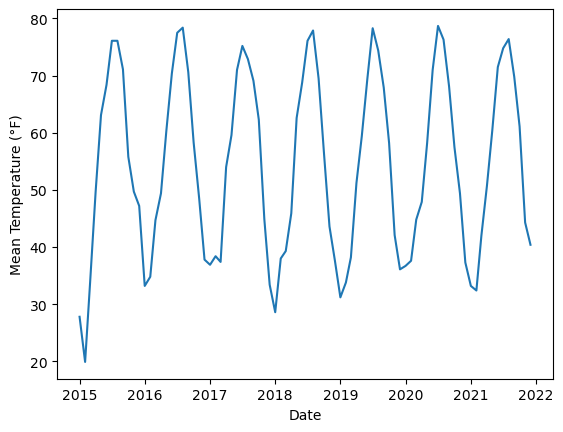

In [13]:
import seaborn as sns
df_temperature=NY_state_annual_temperature.copy()
df_temperature['Date'] = pd.to_datetime(df_temperature['Date'], format = '%Y-%m')
ax= sns.lineplot(data=df_temperature, x='Date', y='Mean Temperature (°F)')

In [14]:
NY_state_annual_temperature["Date"] = NY_state_annual_temperature["Date"].str[:-6]



In [15]:
NY_state_annual_temperature["Date"] = NY_state_annual_temperature["Date"].astype(int)

merging New York State annual temperature dataframe and label_ev_reg

In [16]:
NY_state_annual_temperature = NY_state_annual_temperature.merge(right=label_ev_reg, how='outer', left_on='Date', right_on='Year')[['Date', 'Mean Temperature (°F)']]
NY_state_annual_temperature

,Date,Mean Temperature (°F)
0,2015,27.8
1,2015,27.8
2,2015,27.8
3,2015,27.8
4,2015,27.8
...,...,...
32731,2021,40.4
32732,2021,40.4
32733,2021,40.4
32734,2021,40.4


#### New York State Income DataFrame

Below we are cleaning the data for the New York income, which we will merge to the EV registration dataframe.

In [17]:
NY_state_income = pd.read_csv("Resources/Household_Income_for_New_York_State.csv")
NY_state_income.head()

,Date,US,New York
0,2021,"$69,717","$74,314"
1,2020,"$70,877","$76,630"
2,2019,"$69,638","$76,416"
3,2018,"$66,828","$73,201"
4,2017,"$66,687","$71,725"


In [18]:
NY_state_income['New York'] = NY_state_income['New York'].str.replace('$', '')
NY_state_income['US'] = NY_state_income['US'].str.replace('$', '')
NY_state_income['New York'] = NY_state_income['New York'].str.replace(',', '')
NY_state_income['US'] = NY_state_income['US'].str.replace(',', '')
NY_state_income['New York'] = NY_state_income['New York'].astype(int)
NY_state_income['US'] = NY_state_income['US'].astype(int)

/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [19]:
NY_state_income.dtypes

Date        int64
US          int64
New York    int64
dtype: object

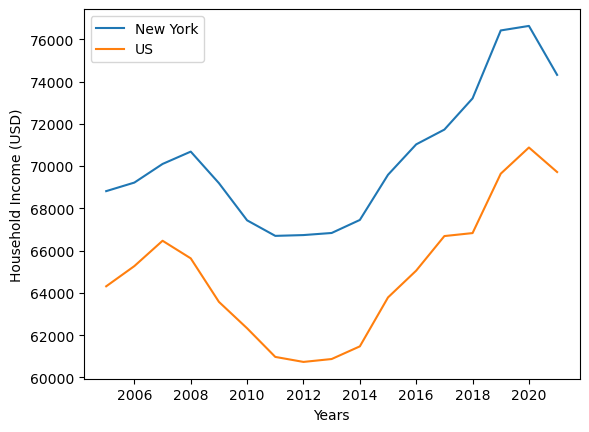

In [20]:
plt.xlabel('Years')
plt.ylabel('Household Income (USD)')
plt.plot(NY_state_income['Date'], NY_state_income['New York'], label='New York');
plt.plot(NY_state_income['Date'], NY_state_income['US'], label='US');
plt.legend();

In [21]:
label_ev_reg.dtypes

Year      int64
Zip      object
Count     int64
dtype: object

merging the dataframes

In [22]:
# NY_income_clean = New York_state_income[New York state_income['Date']].sort_values('Date', ascending=True).reset_index()
NY_income_clean = NY_state_income.merge(label_ev_reg, how='outer', left_on='Date', right_on='Year')[['Date', 'US', 'New York']]
NY_income_clean.head()

,Date,US,New York
0,2021,69717,74314
1,2021,69717,74314
2,2021,69717,74314
3,2021,69717,74314
4,2021,69717,74314


#### Constructing $X$ Matrix of Features and $y$ Vector of Labels 

We are now constructing our set of independent variables and putting it in the matrix $X$.

In [23]:
X = label_ev_reg_ohe.copy()
X = X.drop('Count', axis=1)
X['Temperature'] = NY_state_annual_temperature['Mean Temperature (°F)']
X['Income'] = NY_income_clean['New York']
X

,Year,10001,10002,10003,10004,10005,10006,10007,10009,10010,...,90066,90069,90210,90265,90291,94025,98407,99999,Temperature,Income
0,2015,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.8,74314
1,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.8,74314
2,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.8,74314
3,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.8,74314
4,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.8,74314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2723,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.7,69587
2724,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,36.7,69587
2725,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.7,69587
2726,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.7,69587


In [24]:
y = label_ev_reg[['Year', 'Zip', 'Count']]
y

,Year,Zip,Count
0,2015,10007,1
1,2015,10035,17
2,2015,10038,2
3,2015,10301,1
4,2015,11050,1
...,...,...,...
2723,2021,90066,1
2724,2021,90210,1
2725,2021,90265,2
2726,2021,94025,1


### Training our Model

First, we need to obtain a train-test split, which for our dataset we will use 80% to train and 20% to validate. For our time series model, we will use the years 2015-2020 as our training data, and the years 2021 as testing.

In [25]:
X_train = X[(X['Year'] >= 2015) & (X['Year'] <= 2020)]
X_test = X[(X['Year'] == 2021)]

y_train = y[(y['Year'] >= 2015) & (y['Year'] <= 2020)]
y_test = y[(y['Year'] == 2021)]

#### Linear Model Hypothesis

We preliminarily hypothesize that the EV adoption numbers follow a linear pattern with respect to our features, so we will fit our data using a linear regression model.

In [26]:
model = LinearRegression()
model.fit(X_train, y_train['Count'])

LinearRegression()

In order to make a prediction input that is suitable for our model, we need to include 1586 features, 1583 are one-hot encoded ZIP code features. To make this a bit simpler to use, we will define a helper function below.

In [27]:
def make_prediction_input(year, zip_code, temp, income):
  col = label_ev_reg['Zip']
  values = np.array(col)

  # Encode each value as an integer index
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  zip_code_labels = list(label_encoder.classes_)

  zip_code_input = list(np.zeros(len(zip_code_labels)))
  zip_code_index = label_encoder.transform([str(zip_code)])[0]
  zip_code_input[zip_code_index] = 1
  
  pred_input = []
  pred_input.append(year)
  pred_input.extend(zip_code_input)
  pred_input.append(temp)
  pred_input.append(income)
  return pred_input

In [28]:
pred_input = make_prediction_input(2021, 10301, 48, 74000)
model.predict([pred_input])

/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([42.78024292])

After training our model, we can predict EVs adoption numbers given the year, ZIP code, temperature, and income data of New York state.

As this is a regression task, we can evaluate our model by taking the mean squared error of the prediction vs the true label.

##### Evaluating Our Linear Model

In [29]:
from sklearn.metrics import mean_squared_error

First let us recover the zip code labels from the `label_ev_reg` dataframe.

In [30]:
# Encode each value as an integer index
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(np.array(label_ev_reg['Zip']))
zip_code_labels = list(label_encoder.classes_)

Then, we will evaluate how well we trained our model onto our dataset by using our linear model to predict over each ZIP code of the training data, and then calculate the mean squared error between the prediction and the true result.

37.1498261303305

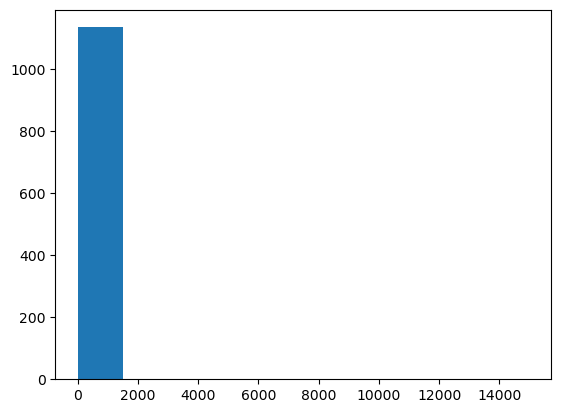

In [31]:
# Predict over data from each zip code
ev_adoption_linear_train = {}
for zip_code in zip_code_labels:
  train_vals = X_train[X_train[zip_code] == 1]
  if len(train_vals) > 0:
    ev_adoption_linear_train[zip_code] = model.predict(train_vals)

# Compute mse between predicted values and true values
mse_dict_train = {}
zip_code_train_outliers = []
for zip_code, nums in ev_adoption_linear_train.items():
  mse = mean_squared_error(nums, y_train[y_train['Zip'] == zip_code]['Count'])
  mse_dict_train[zip_code] = mse

# Plot histogram of mse per zip code, and print out mean of mse over zip codes
plt.hist(mse_dict_train.values());
np.mean(list(mse_dict_train.values()))

Next, we will evaluate how well our model generalizes and can predict future outcomes by predicting over each ZIP code of the test data, and then calculate the mean squared error between the prediction and the true result.

3.9954487786937076e+24

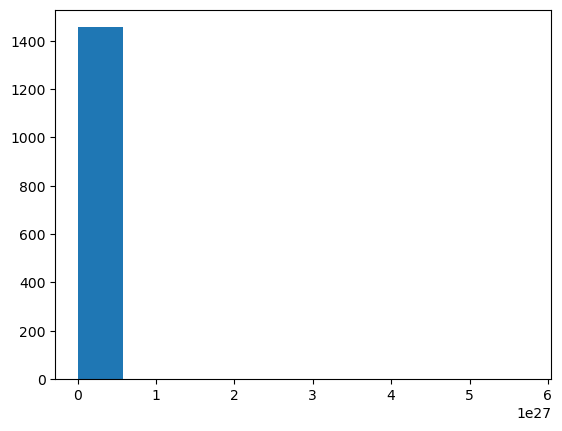

In [32]:
# Predict over data for each zip code of test segment
ev_adoption_linear_test = {}
for zip_code in zip_code_labels:
  test_vals = X_test[X_test[zip_code] == 1]
  if len(test_vals) > 0:
    ev_adoption_linear_test[zip_code] = model.predict(test_vals)

# Compute mse between predicted values and true values
mse_dict_test = {}
for zip_code, nums in ev_adoption_linear_test.items():
  mse = mean_squared_error(nums, y_test[y_test['Zip'] == zip_code]['Count'])
  mse_dict_test[zip_code] = mse

# Plot histogram of mse per zip code, and print out mean of mse over zip codes
plt.hist(mse_dict_test.values());
np.mean(np.array(list(mse_dict_test.values())))

##### Modifications to our Linear Model

We can see from our histogram of mean squared errors that our linear model does not generalize very well for a handful of ZIP codes. This is likely due to the sparsity or perhaps the general lack of the data for those particular ZIP codes. For the sake of this model, let us remove these outlier ZIP codes from our data set and only focus on ZIP codes that our model can perform decently on.

To do this, let us remove the ZIP codes with high mean squared error by placing a threshold that should filter them out.

In [33]:
# Filter out high mse zip code, place in list
threshold = 1e10
zip_code_test_outliers = []
for key, val in list(mse_dict_test.items()):
  if val > threshold:
    zip_code_test_outliers.append(key)
    mse_dict_test.pop(key)

# Print out new mean of filtered mse
np.mean(np.array(list(mse_dict_test.values())))

24699.68594508412

We can see now that the average mean squared errors over each ZIP code is now a lot lower a more reasonable than with the filtered out ZIP codes.

Now, in order modify our linear model to disregard the filtered out ZIP codes, we need to prune them out starting at the level of `label_ev_reg`, and then we need to propagate those changes down to the $X$ matrix, $y$ vector, and the train-test split.

In [34]:
# Remove outlier zip codes from the dataframe, then one hot encode
label_ev_reg_pruned = label_ev_reg[~label_ev_reg['Zip'].isin(zip_code_test_outliers)].reset_index(drop=True)
label_ev_reg_pruned_ohe = one_hot_encode('Zip', label_ev_reg_pruned)

# Create X matrix
X = label_ev_reg_pruned_ohe.copy()
X = X.drop('Count', axis=1)
X['Temperature'] = NY_state_annual_temperature['Mean Temperature (°F)']
X['Income'] = NY_income_clean['New York']

# Create y vector
y = label_ev_reg_pruned[['Year', 'Zip', 'Count']]

# Generate train test split
X_train = X[(X['Year'] >= 2015) & (X['Year'] <= 2020)]
X_test = X[(X['Year'] == 2021)]

y_train = y[(y['Year'] >= 2015) & (y['Year'] <= 2020)]
y_test = y[(y['Year'] == 2021)]

Finally, we will retrain our linear model on the pruned dataset.

In [35]:
model = LinearRegression()
model.fit(X_train, y_train['Count'])

LinearRegression()

#### Auto Regressive Integrated Moving Average Model (ARIMA) 

In [36]:
from statsmodels.tsa.arima_model import ARIMA

The ARIMA model only takes in a series as input and no ZIP code categorical variable, so let us train our model on only some of the more consequential ZIP codes with more data.

In [37]:
label_ev_reg.sort_values('Count', ascending=False).head(10)

,Year,Zip,Count
1549,2021,11231,4171
1555,2021,11237,2664
1412,2021,10583,488
1687,2021,11746,383
1722,2021,11791,309
1686,2021,11743,267
269,2020,10583,262
2617,2021,14850,256
1509,2021,11040,249
2516,2021,14534,229


Let us choose the 11753 ZIP code, which corresponds to JERICHO NY, a city in Nassau County, and let us run the ARIMA model through the time series data provided there.

In [38]:
import statsmodels.api as sm

In [39]:
from statsmodels.tsa.arima.model import ARIMA

In [40]:
predictions = list()
train = np.array(label_ev_reg[label_ev_reg['Zip'] == '11753']['Count']).astype(float)[:8]
test = np.array(y_test[y_test['Zip'] == '11746']['Count'].astype(float))
history = [x for x in train]

for t in range(len(test)):
	arima_model = ARIMA(history, order=(1, 1, 4), seasonal_order=(0, 1, [], 12))
	arima_model_fit = arima_model.fit()
	output = arima_model_fit.forecast()
 
	pred = output[0]
	predictions.append(pred)
	true_val = test[t]
	history.append(true_val)
	print('Predicted=%f, Expected=%f' % (pred, true_val))
 


Predicted=188.000000, Expected=383.000000


/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


After testing the ARIMA model on the the 11753 ZIP code, we saw that it does not actually give us much of an improvement compared to the linear model in terms of mean squared error.

In addition, after doing a bit more research we realized that ARIMA would not be the best model because:

1. Our time series is not necessarily a stationary series, and we do not have enough data to prove that.
2. Our input data is meant to be multivariate, but ARIMA only allows for univariate inputs. This makes training over multiple ZIP codes significantly more difficult.

Let us try to predict the next 30 years, but first we need to generate data for temperature and income in New York state based on some hypotheses.

#### Generating NY Temperature Data 2020-2050

Below we hypothesize that NY state temperature follows a linear pattern, and thus we will generate data based on a linear model. We will also add Gaussian noise based on the standard deviation of the known temperatures.

/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


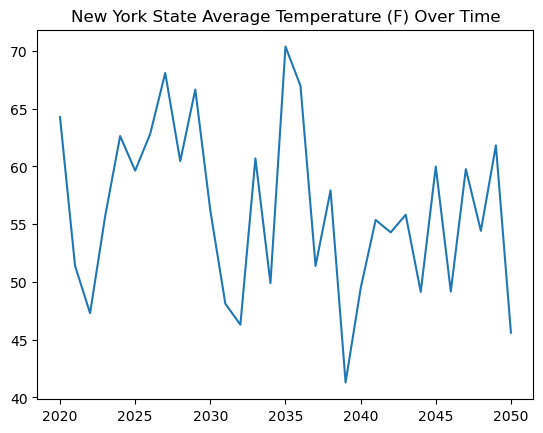

In [41]:
NY_temp_model = LinearRegression()
NY_temp_model.fit(NY_state_annual_temperature[['Date']], NY_state_annual_temperature['Mean Temperature (°F)'])
NY_temp_data = NY_temp_model.predict(np.arange(2020, 2051)[:, np.newaxis])
NY_temp_data = np.add(NY_temp_data, np.random.normal(0, NY_state_annual_temperature['Mean Temperature (°F)'].std() / 2, 31))

plt.title('New York State Average Temperature (F) Over Time')
plt.plot(np.arange(2020, 2051), NY_temp_data);

NY_future_temp_df = pd.DataFrame(data=np.transpose([np.arange(2020, 2051), NY_temp_data]), columns=['Year', 'Temp'])

#### Generating NY State Income Data 2020-2050

Below we hypothesize that NY state income follows a linear pattern, and thus we will generate data based on a linear model. We will also add Gaussian noise based on the standard deviation of the known income.

/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


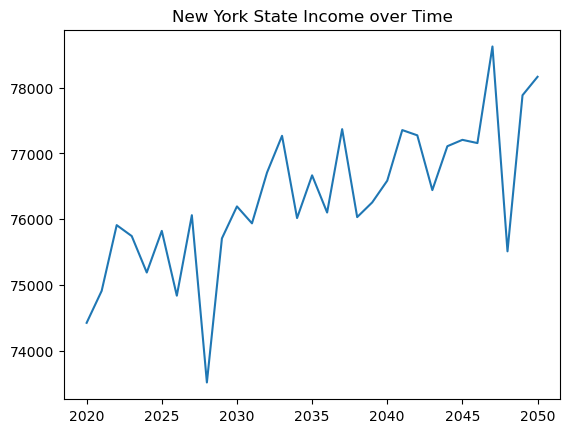

In [42]:
NY_income_model = LinearRegression()
NY_income_model.fit(NY_income_clean[['Date']], NY_income_clean['New York'])
NY_income_data = NY_income_model.predict(np.arange(2020, 2051)[:, np.newaxis])
NY_income_data = np.add(NY_income_data, np.random.normal(0, NY_income_clean['New York'].std() / 2, 31))

plt.title('New York State Income over Time')
plt.plot(np.arange(2020, 2051), NY_income_data);

NY_future_income_df = pd.DataFrame(data=np.transpose([np.arange(2020, 2051), NY_income_data]), columns=['Year', 'Income'])

#### Create Future Matrix to Predict On

Now we will predict on the $X_{future}$, which is based on the future data that we have generated.

In [43]:
# Create dataframe
X_future = pd.DataFrame()
X_future['Year'] = np.arange(2020, 2051)
X_future['key'] = 0

# Get zip code labels
label_encoder = LabelEncoder()
label_encoder.fit_transform(np.array(ev_reg['Zip']))
zip_code_labels = list(label_encoder.classes_)

# Remove outlier zip codes which cannot be predicted well upon
zip_code_labels = [c for c in zip_code_labels if c not in zip_code_test_outliers]

# Cross join year with zip codes
zip_codes_df = pd.DataFrame(data=zip_code_labels, columns=['Zip'])
zip_codes_df['key'] = 0
X_future = X_future.merge(zip_codes_df, how='outer', on='key').drop('key', axis=1)

# One-hot encode zip codes
X_future = one_hot_encode('Zip', X_future)

formatter = lambda x: x / 10

# Add future New York temperatures and income
X_future = X_future.merge(NY_future_temp_df, how='outer', on='Year')
X_future = X_future.merge(NY_future_income_df, how='outer', on='Year')
X_future

,Year,10001,10002,10003,10004,10005,10006,10007,10009,10010,...,8054,83001,85016,8831,88310,90069,90291,98407,Temp,Income
0,2020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.265117,74423.649301
1,2020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.265117,74423.649301
2,2020,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.265117,74423.649301
3,2020,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.265117,74423.649301
4,2020,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.265117,74423.649301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35273,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,45.605837,78165.448769
35274,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,45.605837,78165.448769
35275,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.605837,78165.448769
35276,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,45.605837,78165.448769


/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Temp
Feature names seen at fit time, yet now missing:
- Temperature

  warnings.warn(message, FutureWarning)
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Temp
Feature names seen at fit time, yet now missing:
- Temperature

  warnings.warn(message, FutureWarning)
/Users/hosseindabiri/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Temp


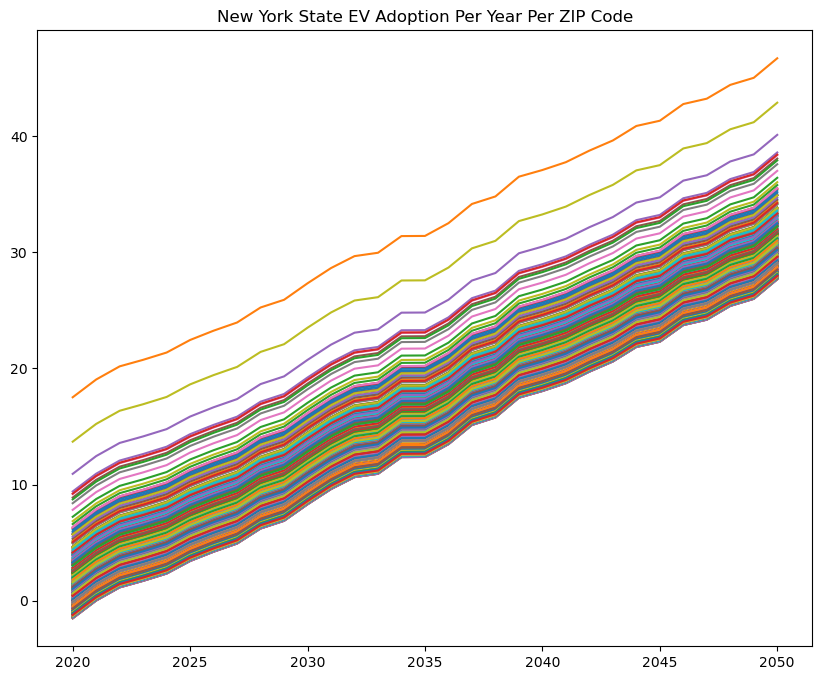

In [44]:
ev_adoption_futures = {}

for zip_code in zip_code_labels:
  ev_adoption_futures[zip_code] = formatter(model.predict(X_future[X_future[zip_code] == 1]))

plt.figure(figsize=(10, 8))
plt.title('New York State EV Adoption Per Year Per ZIP Code')
for zip_code, nums in ev_adoption_futures.items():
  plt.plot(np.arange(2020, 2051), nums);

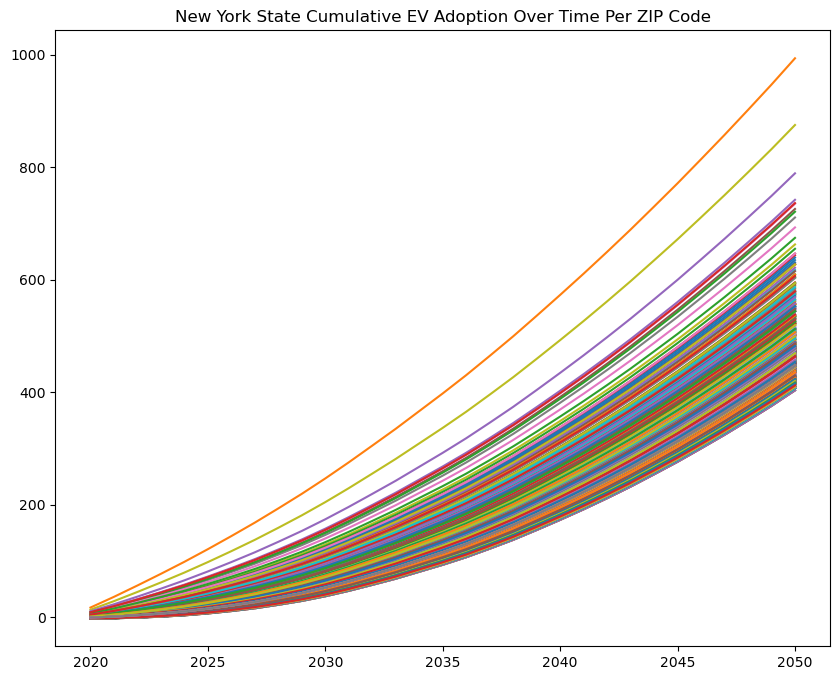

In [45]:
plt.figure(figsize=(10, 8))
plt.title('New York State Cumulative EV Adoption Over Time Per ZIP Code')

for zip_code, nums in ev_adoption_futures.items():
  plt.plot(np.arange(2020, 2051), np.cumsum(nums));

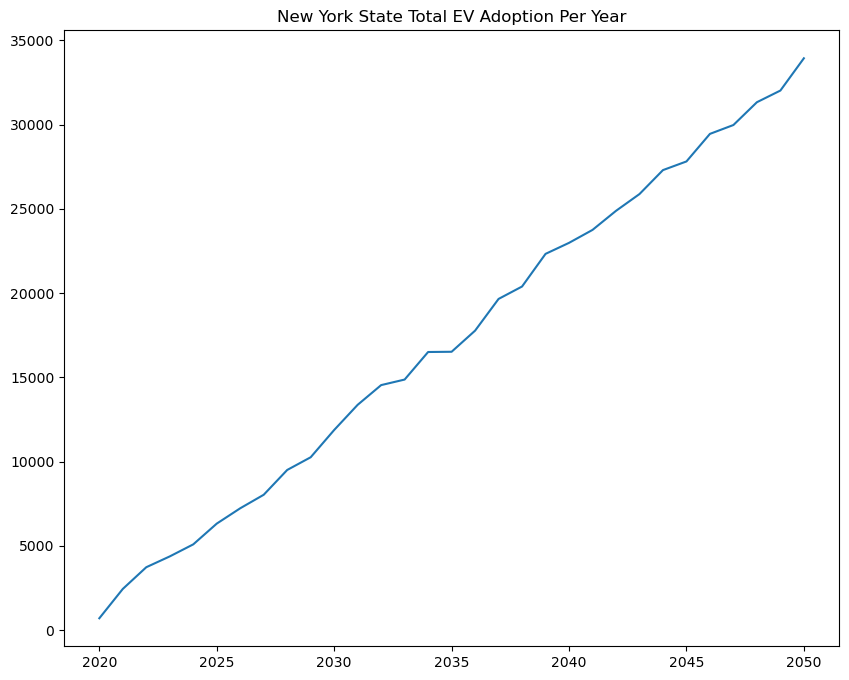

In [46]:
plt.figure(figsize=(10, 8))
plt.title('New York State Total EV Adoption Per Year')
plt.plot(np.arange(2020, 2051), np.sum(np.array([arr for arr in ev_adoption_futures.values()]), axis=0));

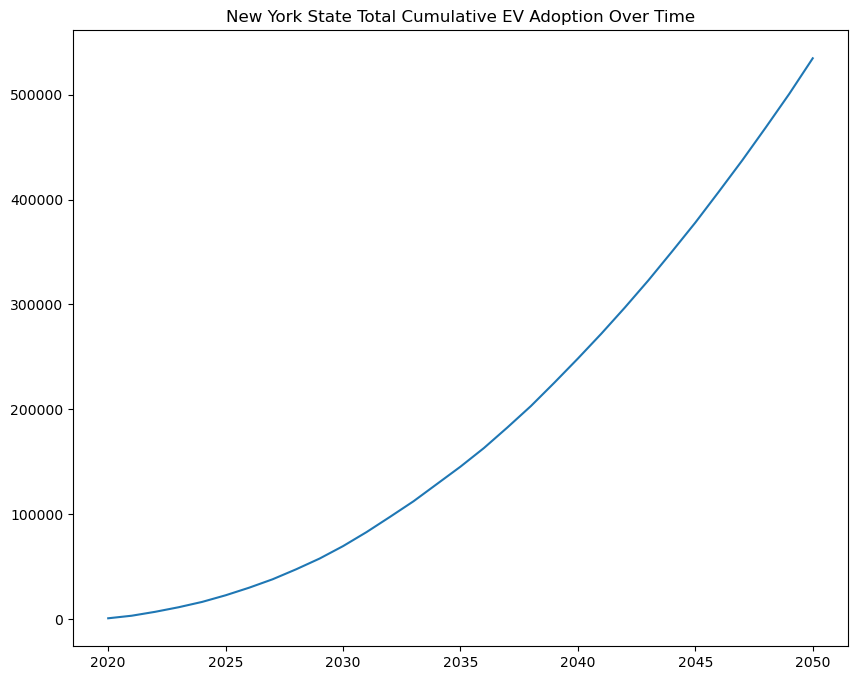

In [47]:
plt.figure(figsize=(10, 8))
plt.title('New York State Total Cumulative EV Adoption Over Time')
plt.plot(np.arange(2020, 2051), np.cumsum(np.sum(np.array([arr for arr in ev_adoption_futures.values()]), axis=0)));

In [48]:
np.cumsum(np.sum(np.array([arr for arr in ev_adoption_futures.values()]), axis=0))

array([   695.40640397,   3133.10251774,   6859.41138741,  11227.49127511,
        16310.07941975,  22623.84617053,  29848.50983789,  37875.49692493,
        47373.86304772,  57626.65531981,  69497.89467987,  82863.06318554,
        97398.13882219, 112262.8116382 , 128762.66252064, 145276.58563558,
       163043.30619887, 182693.24628544, 203080.10597614, 225404.39687315,
       248382.51008071, 272129.18519324, 297007.18031083, 322881.76712004,
       350178.31377971, 377988.35404746, 407434.4024356 , 437407.20892267,
       468732.75354535, 500750.83337004, 534684.53521994])

Here we see that in total, our model predicts that NY state will have over 535000 EVs by 2050.

## Electrical Infrastructure Sustainability Model

Now that we have our forecasting model, we can use its outputs to analyze whether the current electrical infrastructural capacity of our selected geographic region can handle the increased number of EVs.

### New York State Electrical Infrastructure

In [49]:
energy_annual_generation = pd.read_excel("Resources/annual_generation_state.xls", header=1).iloc[:, : 5]

We will explore the electrical production and electrical usage of NY State, and we will tie this data in with the influx of the EV population that we saw earlier. NOTE that all of the energy numbers are in megawatthours (MWh). Here we have a dataset which has data with a detailed breakdown of energy generation per state and through what energy source starting from 1990 to 2020.Meanwhile here we have a dataset which has a breakdown of energy consumption per state per year from 2000 to 2018.

In [50]:
energy_annual_generation.head()

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,1990,AK,Total Electric Power Industry,Total,5599506.0
1,1990,AK,Total Electric Power Industry,Coal,510573.0
2,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521.0
3,1990,AK,Total Electric Power Industry,Natural Gas,3466261.0
4,1990,AK,Total Electric Power Industry,Petroleum,497116.0


In [51]:
energy_annual_generation['GENERATION (Megawatthours)'] = energy_annual_generation['GENERATION (Megawatthours)'].astype(str)

In [52]:
energy_annual_generation_NY = energy_annual_generation[(energy_annual_generation['STATE'] == 'NY') & \
                         (energy_annual_generation['TYPE OF PRODUCER'] == 'Total Electric Power Industry')].reset_index(drop=True)

energy_annual_generation_NY['YEAR'] = [int(year) for year in energy_annual_generation_NY['YEAR']]
energy_annual_generation_NY['GENERATION (Megawatthours)'] = [int(num.replace('.', '')) for num in energy_annual_generation_NY['GENERATION (Megawatthours)']]

energy_annual_generation_NY.head()

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,1990,NY,Total Electric Power Industry,Total,1353456920
1,1990,NY,Total Electric Power Industry,Coal,259130470
2,1990,NY,Total Electric Power Industry,Hydroelectric Conventional,281882220
3,1990,NY,Total Electric Power Industry,Natural Gas,227243350
4,1990,NY,Total Electric Power Industry,Nuclear,236233560


In [53]:
#energy_annual_generation['GENERATION (Megawatthours)'] = energy_annual_generation['GENERATION (Megawatthours)'].astype(int)

We are also interested in the energy proportion that is generated from clean, renewable resources, so we will also calculate the breakdown of energy generation by source.

In [54]:
energy_proportion = []
curr_year, curr_total = 0, 0
for index, row in energy_annual_generation_NY.iterrows():
  if row[0] != curr_year:
    curr_year = row[0]
    curr_total = row[4]
    energy_proportion.append(1)
  else:
    energy_proportion.append(row[4] / curr_total)

energy_annual_generation_NY['Proportion of Energy in Year'] = energy_proportion

Here is a snapshot of what the proportions column looks like, where `ENERGY SOURCE == Total` equals 1 because it represents total generation.

In [55]:
energy_annual_generation_NY[energy_annual_generation_NY['YEAR'] == 2020]

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),Proportion of Energy in Year
336,2020,NY,Total Electric Power Industry,Total,1294302710,1.000000
337,2020,NY,Total Electric Power Industry,Coal,1436920,0.001110
338,2020,NY,Total Electric Power Industry,Pumped Storage,-3279480,-0.002534
339,2020,NY,Total Electric Power Industry,Hydroelectric Conventional,295498820,0.228307
340,2020,NY,Total Electric Power Industry,Natural Gas,529655930,0.409221
341,2020,NY,Total Electric Power Industry,Nuclear,384300760,0.296917
342,2020,NY,Total Electric Power Industry,Other Gases,0,0.000000
343,2020,NY,Total Electric Power Industry,Other,9971380,0.007704
344,2020,NY,Total Electric Power Industry,Petroleum,3496510,0.002701
345,2020,NY,Total Electric Power Industry,Solar Thermal and Photovoltaic,8399580,0.006490


We will calculate the average renewable energies total by filtering by renewable energy sources, such as hydroelectric and solar, grouping and summing over year, and then taking the average of the proportions over the years.

We can see here that around 22% of New York state's energy generation comes from renewable sources, which is quite remarkable.

In [56]:
renewable_energy = ['Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Other Biomass', 'Wind']
energy_annual_generation_NY[energy_annual_generation_NY['ENERGY SOURCE'].isin(renewable_energy)].groupby('YEAR').sum()['Proportion of Energy in Year'].mean()

0.22295724385604232

#### Calculating Energy Surplus per Year

Since we have the energy generation and consumption numbers per year, we can merge the tables together and calculate the average surplus.

In [57]:
energy_sales_annual = pd.read_csv("Resources/energy_sales_annual.csv")

energy_sales_annual

,YEAR,Residential,Commercial,Industrial,Transportation,Total
0,2000,125047564.2,117544944.8,41264406.68,106291015.7,390147931.5
1,2001,126008837.3,118447603.7,41583854.15,107105753.3,393146048.5
2,2002,132673273.5,124713463.2,43781887.17,112773747.8,413942371.6
3,2003,133789874.2,125762657.6,44151156.72,113720367.4,417424056.0
4,2004,135483825.0,127356964.3,44710922.47,115162277.0,422713988.8
5,2005,142535115.0,133983301.2,47037906.76,121155580.4,444711903.3
6,2006,141729169.5,133224247.1,46771212.09,120469794.1,442194422.8
7,2007,145999215.0,137239320.7,48180883.94,124098014.0,455517433.7
8,2008,144782970.1,136096343.6,47779376.57,123066403.8,451725094.0
9,2009,143115395.7,134528413.3,47228402.96,121647939.8,446520151.8


In [58]:
merged_table = energy_annual_generation_NY[energy_annual_generation_NY['ENERGY SOURCE'] == 'Total'] \
              .merge(right=energy_sales_annual, how='inner', left_on='YEAR', right_on='YEAR')

merged_table.head()

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),Proportion of Energy in Year,Residential,Commercial,Industrial,Transportation,Total
0,2000,NY,Total Electric Power Industry,Total,1380790750,1.0,125047564.2,117544944.8,41264406.68,106291015.7,390147931.5
1,2001,NY,Total Electric Power Industry,Total,1439145590,1.0,126008837.3,118447603.7,41583854.15,107105753.3,393146048.5
2,2002,NY,Total Electric Power Industry,Total,1395916880,1.0,132673273.5,124713463.2,43781887.17,112773747.8,413942371.6
3,2003,NY,Total Electric Power Industry,Total,1376433160,1.0,133789874.2,125762657.6,44151156.72,113720367.4,417424056.0
4,2004,NY,Total Electric Power Industry,Total,1379647940,1.0,135483825.0,127356964.3,44710922.47,115162277.0,422713988.8


In [59]:
merged_table['Energy Surplus'] = merged_table['GENERATION (Megawatthours)'] - merged_table['Total'] 
merged_table.head()

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours),Proportion of Energy in Year,Residential,Commercial,Industrial,Transportation,Total,Energy Surplus
0,2000,NY,Total Electric Power Industry,Total,1380790750,1.0,125047564.2,117544944.8,41264406.68,106291015.7,390147931.5,9.906428e+08
1,2001,NY,Total Electric Power Industry,Total,1439145590,1.0,126008837.3,118447603.7,41583854.15,107105753.3,393146048.5,1.046000e+09
2,2002,NY,Total Electric Power Industry,Total,1395916880,1.0,132673273.5,124713463.2,43781887.17,112773747.8,413942371.6,9.819745e+08
3,2003,NY,Total Electric Power Industry,Total,1376433160,1.0,133789874.2,125762657.6,44151156.72,113720367.4,417424056.0,9.590091e+08
4,2004,NY,Total Electric Power Industry,Total,1379647940,1.0,135483825.0,127356964.3,44710922.47,115162277.0,422713988.8,9.569340e+08


In [60]:
merged_table[['Energy Surplus']].describe()

,Energy Surplus
count,2.200000e+01
mean,2.038191e+09
std,3.619623e+09
min,7.663451e+08
25%,8.828156e+08
50%,9.389575e+08
75%,9.884757e+08
max,1.328252e+10


In [61]:
merged_table['Energy Surplus'].mean()

2038191302.7863634

#### Calculating Energy Surplus per ZIP Code

Here we will load in a current New York state population by ZIP code file, and then compute the proportion of the population in each ZIP code.

In [147]:

data=pd.read_csv("Resources/NY_state_population_by_zip.csv")
pop_df = pd.DataFrame(data)



pop_df

,ZIP,Population
0,14526,19804.0
1,14580,50587.0
2,12983,7494.0
3,14744,2094.0
4,10305,41749.0
...,...,...
3079,14222,14046.0
3080,10314,85510.0
3081,12834,6594.0
3082,13440,42986.0


In [148]:
pop_df.dropna(inplace=True)

In [149]:
#checking the ducplicates
ids=pop_df['ZIP']
pop_df[ids.isin(ids[ids.duplicated()])]

,ZIP,Population
0,14526,19804.0
1,14580,50587.0
2,12983,7494.0
3,14744,2094.0
4,10305,41749.0
...,...,...
3079,14222,14046.0
3080,10314,85510.0
3081,12834,6594.0
3082,13440,42986.0


In [150]:
pop_df.drop_duplicates("ZIP", keep=False, inplace= True)

In [151]:
pop_df['Proportion of Population'] = pop_df['Population'] / np.sum(pop_df['Population'])


Now, we will use population as an approximate measure of how energy is distribued in the state of NY.

In [152]:
pop_df['Energy Surplus per ZIP Code'] = pop_df['Proportion of Population'] * merged_table['Energy Surplus'].mean()
pop_df

,ZIP,Population,Proportion of Population,Energy Surplus per ZIP Code
14,11212,84500.0,0.024961,5.087481e+07
43,11766,12635.0,0.003732,7.607139e+06
46,11705,8030.0,0.002372,4.834612e+06
58,11732,3430.0,0.001013,2.065096e+06
77,13365,8906.0,0.002631,5.362025e+06
...,...,...,...,...
3037,10603,17045.0,0.005035,1.026226e+07
3049,12546,3039.0,0.000898,1.829687e+06
3050,12856,187.0,0.000055,1.125869e+05
3071,12919,3037.0,0.000897,1.828483e+06


### Combining EV Adoption with Electrical Infrastructure

On average, EVs get somewhere within the range of 2 to 3 mi/kWh, so we can use 2.5 mi/kWh as our number. American drivers average 15000 miles driven per year, so this comes down to 6000 kWh per year, or 6 MWh per year. Given that the energy surplus average is around 17 million MWh, the state of NY can support about 2.83 million EVs using the energy surplus.

If we only consider 77% of the surplus, which is the average percentage of energy that is supplied through renewable sources, then we have about 13 million MWh of surplus, which can support about 2.18 million EVs. This actually means that even with our projected 1 million addition of EVs by 2050,
NY state will still have enough renewable energy capacity to support all of them overall.

However, it is different per ZIP code, and it turns out that there some ZIP codes in NY state that already do not have much surplus energy capacity that may struggle upon an influx of EVs being purchased.

In [153]:
pop_df['EVs Supported by Surplus'] = pop_df['Energy Surplus per ZIP Code'] / 6
pop_df.head()

,ZIP,Population,Proportion of Population,Energy Surplus per ZIP Code,EVs Supported by Surplus
14,11212,84500.0,0.024961,5.087481e+07,8.479135e+06
43,11766,12635.0,0.003732,7.607139e+06,1.267857e+06
46,11705,8030.0,0.002372,4.834612e+06,8.057687e+05
58,11732,3430.0,0.001013,2.065096e+06,3.441827e+05
77,13365,8906.0,0.002631,5.362025e+06,8.936708e+05


In [154]:
np.sum(pop_df['EVs Supported by Surplus'])

339698550.46439385

NY state can support 339698550 EVs through Energy Surplus 

Below, let us take the average energy surplus across each ZIP code and subtract that predicted number of EVs that will be purchased over the years 2021 to 2050. This will give us the remainder of how many more EVs each ZIP code can support.

In [144]:
energy_surplus_ev_zip_code = {}

for zip_code, nums in ev_adoption_futures.items():

  if not pop_df[pop_df['ZIP'] == int(zip_code)].empty:
    energy_surplus_ev_zip_code[zip_code] = (pop_df[pop_df['ZIP'] == int(zip_code)]['EVs Supported by Surplus']) * np.ones(len(nums)) - np.cumsum(nums)



ValueError: Length of values (31) does not match length of index (1)

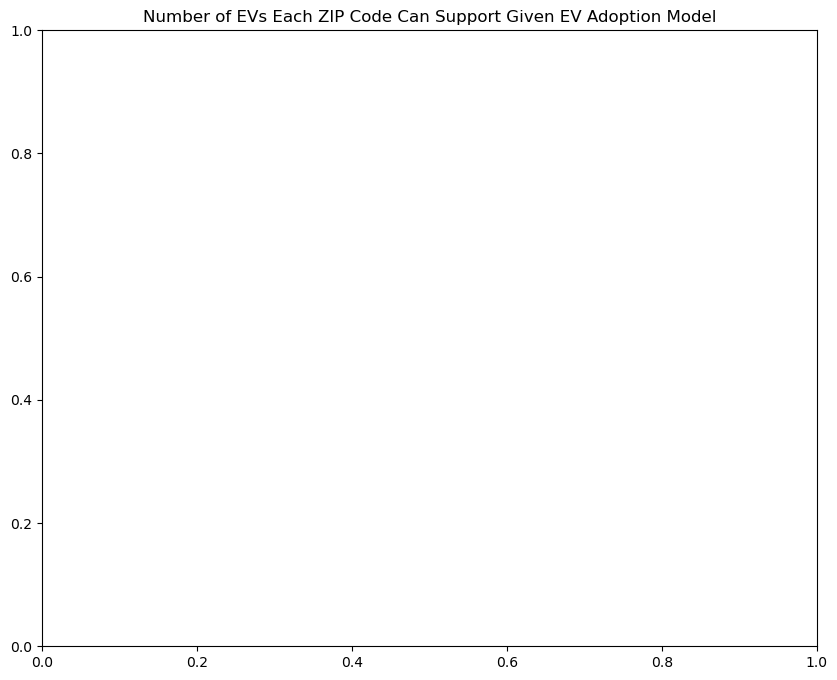

In [73]:
plt.figure(figsize=(10, 8))
plt.title('Number of EVs Each ZIP Code Can Support Given EV Adoption Model')
for zip_code, nums in energy_surplus_ev_zip_code.items():
  plt.plot(np.arange(2020, 2051), nums)

ValueError: x and y must have same first dimension, but have shapes (31,) and (1,)

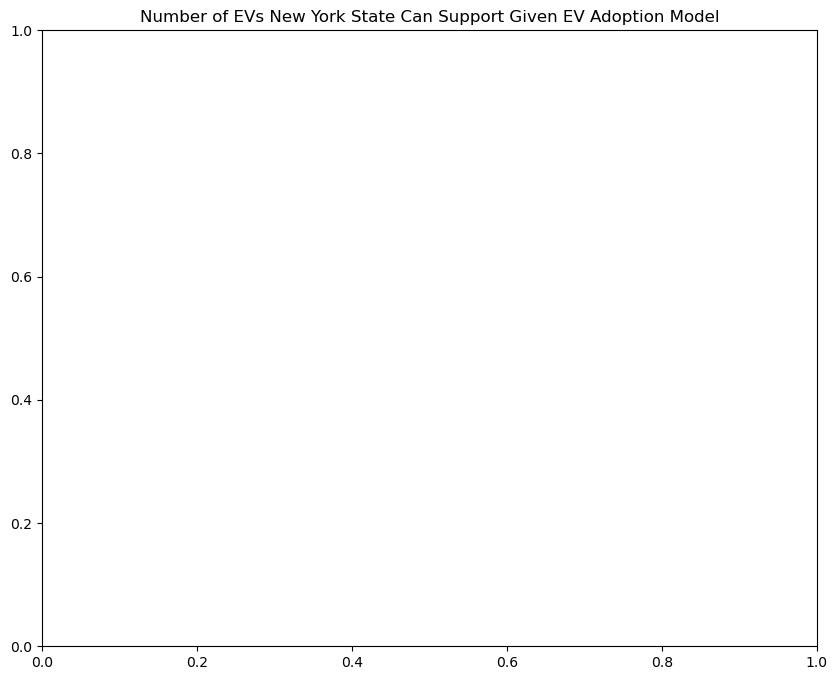

In [74]:
plt.figure(figsize=(10, 8))
plt.title('Number of EVs New York State Can Support Given EV Adoption Model')
plt.plot(np.arange(2020, 2051), np.sum(np.array([arr for arr in energy_surplus_ev_zip_code.values()]), axis=0));